In [68]:
from torch_geometric.nn import GATConv
from torch_geometric.nn import SAGEConv
from igraph import Graph
from torch_geometric.utils import dense_to_sparse
from torch.nn import ModuleList
import igraph as ig
import numpy as np
import json
import pandas as pd
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import (v_measure_score, homogeneity_score, completeness_score)
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn.parameter import Parameter
import scipy.sparse as sp
from torch.nn.modules.module import Module
from sklearn.metrics import classification_report
import torch.optim as optim
from torch.autograd import Variable
import time
import math
import neptune
import os
import random

seed=42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [69]:
seed=42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

node_list_path = r'C:\Users\George\Desktop\ISEF-2023\Datas\Node list\back up\current_protein_Signal+meta+targets.json'
with open(node_list_path, 'r') as file:
    node_list = json.load(file)
graph = r'C:\Users\George\Desktop\ISEF-2023\Network construction\PPI_homo_graph_features_loaded.graphml'
# Create an igraph object
PPI_graph = ig.Graph.Load(graph, format='graphml')

feature_keys = [
    "Indegree", "Outdegree", "Closeness", "Betweenness", "Pagerank", "Cluster_coefficients",
    "Nearest_Neighbor_Degree", "Similarity", "Subunit", "Transmembrane",
    "Catalytic_activity", "Interaction", "Tissue_Specificity", "Disease",
    "Sequence_conflict", "Modified_residue", "Function", "Binding_site",
    "Natural_variant", "Alternative_products", "Subcellular_location",
    "Active_site", "Disulfide_bond", "Mutagenesis", "PTM", "STP_involvement"
]

features = torch.tensor([
    PPI_graph.vs[key] for key in feature_keys
], dtype=torch.float).t()

edge_indices = torch.tensor(PPI_graph.get_edgelist(), dtype=torch.long).t()

# Assuming you have a label attribute in your graph
labels = torch.tensor(PPI_graph.vs["label"], dtype=torch.float)

# Create a PyTorch Geometric Data object
data = Data(x=features, edge_index=edge_indices, y=labels)

print(data)

random_seed = 42

Data(x=[7392, 26], edge_index=[2, 49502], y=[7392])


C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\igraph\io\files.py:295: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:492
  return reader(f, *args, **kwds)


In [70]:
def normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def add_edges(adj_real, adj_new):
    adj = adj_real+adj_new
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    adj = normalize(adj + sp.eye(adj.shape[0]))
    adj = sparse_mx_to_torch_sparse_tensor(adj)
    return adj

def accuracy(output, labels, output_AUC):
    preds = output.max(1)[1].type_as(labels)

    confusion_mat = confusion_matrix(labels, preds)

    recall = recall_score(labels.cpu().numpy(), preds.cpu().numpy(), zero_division=0)
    f1_score_ = f1_score(labels.cpu().numpy(), preds.cpu().numpy())
    AUC = roc_auc_score(labels.cpu().numpy(), output_AUC.detach().cpu().numpy())
    acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
    precision = precision_score(labels.cpu().numpy(), preds.cpu().numpy(), zero_division=0)
    return recall, f1_score_, AUC, acc, precision, confusion_mat

def load_data(data, ratio_generated):
    print('Processing graph data...')
    global idx_train, idx_test
    # Extract features and labels from the PyTorch Geometric Data object
    features = data.x
    labels = data.y

    # Convert train and test edge indices to standard numpy arrays for processing
    idx_train = idx_train
    idx_train = idx_train
    # The rest of the code remains largely the same as in your original function
    majority = np.array([x for x in idx_train if labels[x] == 0])
    minority = np.array([x for x in idx_train if labels[x] == 1])

    num_minority = minority.shape[0]
    num_majority = majority.shape[0]
    print("Number of majority: ", num_majority)
    print("Number of minority: ", num_minority)

    generate_node = []
    generate_label = []
    for i in range(len(labels), len(labels) + int(ratio_generated * num_majority) - num_minority):
        generate_node.append(i)
        generate_label.append(1)
    idx_train = np.hstack((idx_train, np.array(generate_node)))

    minority_test = np.array([x for x in idx_test if labels[x] == 1])
    minority_all = np.hstack((minority, minority_test))

    labels = np.hstack((labels, np.array(generate_label)))

    # Construct adjacency matrix from PyTorch Geometric Data
    edge_index = data.edge_index.numpy()
    adj_real = sp.coo_matrix((np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])), 
                             shape=(len(labels), len(labels)), dtype=np.float32)

    adj = adj_real + adj_real.T.multiply(adj_real.T > adj_real) - adj_real.multiply(adj_real.T > adj_real)

    # Normalizing features and adjacency matrix
    features = normalize(sp.csr_matrix(features))
    adj = normalize(adj + sp.eye(adj.shape[0]))

    # Convert to PyTorch tensors
    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels)
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_test = torch.LongTensor(idx_test)
    generate_node = torch.LongTensor(np.array(generate_node))
    minority = torch.LongTensor(minority)
    majority = torch.LongTensor(majority)
    minority_all = torch.LongTensor(minority_all)

    return adj, adj_real, features, labels, idx_train, idx_test, generate_node, minority, majority, minority_all

In [71]:
class GAT(nn.Module):
    def __init__(self, nfeat, layer_channels, nclass, dropout, generate_node, min_node, alpha, discriminator_type):
        super(GAT, self).__init__()
        
        self.convs = ModuleList()

        # Add the input layer
        self.convs.append(GATConv(nfeat, layer_channels[0], dropout=dropout, concat=True))
        for i in range(1, len(layer_channels)):
            self.convs.append(GATConv(layer_channels[i-1], layer_channels[i], dropout=dropout, concat=True))
            
        self.gc_nclass = GATConv(layer_channels[-1], nclass, dropout=dropout, concat=False)
        self.gc_2 = GATConv(layer_channels[-1], 2, dropout=dropout, concat=False)
        if discriminator_type == 1:
            self.attention = CNNDiscriminator(nfeat*2, 1)
        else:
            self.attention = Attention(nfeat*2, 1)  # Custom attention mechanism, make sure to define or adapt it
        self.generate_node = generate_node
        self.min_node = min_node
        self.dropout = dropout
        self.eps = 1e-10

    def forward(self, x, adj):
        if adj.is_sparse:
            # If adj is already a sparse tensor, directly use the indices
            edge_index = adj._indices()
        else:
            # If adj is a dense tensor, convert it to a sparse format
            edge_index, _ = dense_to_sparse(adj)

        for layer in self.convs:
            x = F.relu(layer(x, edge_index))
            x = F.dropout(x, self.dropout, training=self.training)
 
        x1 = self.gc_nclass(x, edge_index)
        x2 = self.gc_2(x, edge_index)
        return F.log_softmax(x1, dim=1), F.log_softmax(x2, dim=1), F.softmax(x1, dim=1)[:,-1]

    def get_embedding(self, x, adj):
        if adj.is_sparse:
            # If adj is already a sparse tensor, directly use the indices
            edge_index = adj._indices()
        else:
            # If adj is a dense tensor, convert it to a sparse format
            edge_index, _ = dense_to_sparse(adj)
        for layer in self.convs:
            x = F.relu(layer(x, edge_index))

        return x

In [72]:
class GraphSAGE(nn.Module):
    def __init__(self, nfeat, layer_channels, nclass, dropout, generate_node, min_node, alpha, discriminator_type):
        super(GraphSAGE, self).__init__()
        
        self.convs = ModuleList()

        # Add the input layer
        self.convs.append(SAGEConv(nfeat, layer_channels[0], dropout=dropout, concat=True))
        for i in range(1, len(layer_channels)):
            self.convs.append(SAGEConv(layer_channels[i-1], layer_channels[i], dropout=dropout, concat=True))
            
        self.gc_nclass = SAGEConv(layer_channels[-1], nclass, dropout=dropout, concat=False)
        self.gc_2 = SAGEConv(layer_channels[-1], 2, dropout=dropout, concat=False)
        if discriminator_type == 1:
            self.attention = CNNDiscriminator(nfeat*2, 1)
        else:
            self.attention = Attention(nfeat*2, 1)  # Custom attention mechanism, make sure to define or adapt it
        self.generate_node = generate_node
        self.min_node = min_node
        self.dropout = dropout
        self.eps = 1e-10

    def forward(self, x, adj):
        if adj.is_sparse:
            # If adj is already a sparse tensor, directly use the indices
            edge_index = adj._indices()
        else:
            # If adj is a dense tensor, convert it to a sparse format
            edge_index, _ = dense_to_sparse(adj)

        for layer in self.convs:
            x = F.relu(layer(x, edge_index))
            x = F.dropout(x, self.dropout, training=self.training)
 
        x1 = self.gc_nclass(x, edge_index)
        x2 = self.gc_2(x, edge_index)
        return F.log_softmax(x1, dim=1), F.log_softmax(x2, dim=1), F.softmax(x1, dim=1)[:,-1]

    def get_embedding(self, x, adj):
        if adj.is_sparse:
            # If adj is already a sparse tensor, directly use the indices
            edge_index = adj._indices()
        else:
            # If adj is a dense tensor, convert it to a sparse format
            edge_index, _ = dense_to_sparse(adj)
        for layer in self.convs:
            x = F.relu(layer(x, edge_index))

        return x

In [73]:
class GraphConvolution(Module):

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [74]:
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha
        self.concat = concat

        self.W = Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        h = torch.mm(input, self.W)
        N = h.size()[0]

        a_input = self._prepare_attentional_mechanism_input(h)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))
        
        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def _prepare_attentional_mechanism_input(self, Wh):
        # Instead of calculating the outer product of Wh, compute pairwise attention in a more memory-efficient way
        N = Wh.size()[0]  # number of nodes
        Wh_repeated_in_chunks = Wh.repeat_interleave(N, dim=0)
        Wh_repeated_alternating = Wh.repeat(N, 1)
        all_combinations_matrix = torch.cat([Wh_repeated_in_chunks, Wh_repeated_alternating], dim=1)
        return all_combinations_matrix.view(N, N, -1)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [75]:
class Attention(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Attention, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2, bias=True),
            nn.ReLU(),
            nn.Linear(input_dim // 2, output_dim, bias=True),
        )

    def forward(self, x):
        return self.mlp(x)

In [76]:
class GCN(nn.Module):
    def __init__(self, nfeat, layer_channels, nclass, dropout, generate_node, min_node, discriminator_type):
        super(GCN, self).__init__()
        
        self.convs = torch.nn.ModuleList()

        # Add the input layer
        self.convs.append(GraphConvolution(nfeat, layer_channels[0]))
        for i in range(1, len(layer_channels)):
            self.convs.append(GraphConvolution(layer_channels[i-1], layer_channels[i]))
            
        self.gc_nclass = GraphConvolution(layer_channels[-1], nclass)
        self.gc_2 = GraphConvolution(layer_channels[-1], 2)
        if discriminator_type == 1:
            self.attention = CNNDiscriminator(nfeat*2, 1)
        else:
            self.attention = Attention(nfeat*2, 1)
        self.generate_node = generate_node
        self.min_node = min_node
        self.dropout = dropout
        self.eps = 1e-10

    def forward(self, x, adj):
        
        for layer in self.convs:
            x = F.relu(layer(x, adj))
            x = F.dropout(x, self.dropout, training=self.training)
 
        x1 = self.gc_nclass(x, adj)
        x2 = self.gc_2(x, adj)
        return F.log_softmax(x1, dim=1), F.log_softmax(x2, dim=1), F.softmax(x1, dim=1)[:,-1]

    def get_embedding(self,x , adj):
        
        for layer in self.convs:
            x = F.relu(layer(x, adj))
            x = torch.spmm(adj, x)

        return x

In [77]:
class Generator(nn.Module):
    def __init__(self,  dim):
        super(Generator, self).__init__( )

        self.fc1 = nn.Linear(100, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, dim)
        self.fc4 = nn.Tanh()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.fc4(x)
        x = (x+1)/2
        return x

In [78]:
class CNNGenerator(nn.Module):
    def __init__(self, dim):
        super(CNNGenerator, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv1d(1, 10, kernel_size=10, stride=2, padding=0)  # Reducing 100 to 50
        self.conv2 = nn.Conv1d(10, 10, kernel_size=4, stride=1, padding=0)  # Reducing 50 to 47
        self.fc1 = nn.Linear(430, 200)  # Flatten and match to 200
        self.fc2 = nn.Linear(200, 200)  # Fully connected layer 200 to 200
        self.fc3 = nn.Linear(200, dim)  # Fully connected layer 200 to dim

    def forward(self, x):
        # Reshape input and apply convolutions
        x = x.view(x.size(0), 1, -1)  # Reshape: [batch_size, channels=1, length=100]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # Flatten and apply fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # Apply Tanh activation and rescale to [0, 1]
        x = torch.tanh(x)
        return (x + 1) / 2

In [112]:
class CNNDiscriminator(nn.Module):
    def __init__(self, input_channels, feature_map_size):
        super(CNNDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(input_channels, feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size * 2, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


In [148]:
def train(features, adj):
    global max_recall, test_recall, test_f1, test_AUC, test_acc, test_pre, confusion
    model.train()
    optimizer.zero_grad()
    output, output_gen, output_AUC = model(features, adj)

    labels_true = torch.cat((torch.LongTensor(num_real).fill_(0), torch.LongTensor(num_false).fill_(1)))

    if cuda:
        labels_true=labels_true.cuda()

    loss_dis = - euclidean_dist(features[minority], features[majority]).mean()
    #F.nll_loss(output[idx_train], labels[idx_train])
    loss_train =  F.nll_loss(output[idx_train], labels[idx_train]) + F.nll_loss(output_gen[idx_train], labels_true) + loss_dis

    loss_train.backward()
    optimizer.step()


    if not fastmode:
        model.eval()
        output, output_gen, output_AUC = model(features, adj)


    recall_val, f1_val, AUC_val, acc_val, pre_val, conf_val = accuracy(output[idx_val], labels[idx_val], output_AUC[idx_val])
    recall_train, f1_train, AUC_train, acc_train, pre_train, conf_train = accuracy(output[idx_val], labels[idx_val], output_AUC[idx_val])

    output, output_gen, output_AUC = model(features, adj)
    recall_tmp, f1_tmp, AUC_tmp, acc_tmp, pre_tmp, conf = accuracy(output[idx_test], labels[idx_test], output_AUC[idx_test])
    test_recall = recall_tmp
    test_f1 = f1_tmp
    test_AUC = AUC_tmp
    test_acc = acc_tmp
    test_pre = pre_tmp
    max_recall = (recall_val + acc_val)/2
    confusion = conf

    return test_recall, test_pre, test_f1, test_AUC, test_acc, confusion, loss_train


def euclidean_dist(x, y):
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(y, 2).sum(1, keepdim=True).expand(n, m).t()
    dist = xx + yy
    dist.addmm_(1, -2, x, y.t())
    dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
    return dist


In [149]:
seed=42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


targets = np.array([x for x in range(7392) if data.y[x] == 1])
ntargets = np.array([x for x in range(7392) if data.y[x] == 0])

targets_train, targets_test, train_label_1, test_label_1 = train_test_split(targets, np.ones(len(targets)), test_size=0.3)
ntargets_train, ntargets_test, train_label_0,test_label_0 = train_test_split(ntargets, np.zeros(len(ntargets)), test_size=0.3)

idx_train = np.concatenate((np.array(targets_train),np.array(ntargets_train)))
idx_test = np.concatenate((ntargets_test, targets_test))

idx_train_origin = idx_train
print(idx_train.shape, idx_test.shape)



(5174,) (2218,)


In [150]:
#RUn this cell to train one and evaluate one set of hyperparameter. Before running this cell, run the cell above.
#Every time you run this cell, run the cell above first

#hyper parameter#################
#################################
#################################


ratio = 1
#hidden1 = 52
#hidden2 = 26
discriminator_type = 0 #1 for CNN, 0 for NN
layer_type = 1 #0 for GCN, 1 for GAT, 2 for GraphSage
layer_channels = [52, 26]
dropout = 0.3 #0.2, 0.25, 0.3, 0.4, 0.5
lr = 0.01
weight_decay = 0.0004   #0.0003, 0.0004, 0.0005, 0.0007, 0.0009, 0.001, 0.002, 0.003
fastmode = False
no_cuda = False
num= 10
seed= 42
epochs_gen = 12
epochs = 18
alpha = 20

###############################
###############################
###############################

np.random.seed(seed)
torch.manual_seed(seed)

cuda = not no_cuda and torch.cuda.is_available()

adj, adj_real, features, labels, idx_temp, idx_test, generate_node, minority, majority, minority_all = load_data(data, ratio)

print(adj.shape, adj_real.shape, features.shape, labels.shape, idx_temp.shape, idx_test.shape, generate_node.shape, minority.shape, majority.shape, minority_all.shape)

# Model and optimizer
if layer_type == 0:
    
    model = GCN(nfeat=features.shape[1],
    layer_channels = layer_channels,
    nclass=labels.max().item() + 1,
    dropout=dropout,
    generate_node= generate_node,
    min_node = minority, discriminator_type=discriminator_type)
    
elif layer_type == 1:
    
    model = GAT(nfeat=features.shape[1],
    layer_channels = layer_channels,
    nclass=labels.max().item() + 1,
    dropout=dropout,
    generate_node= generate_node,
    min_node = minority, alpha=alpha, discriminator_type=discriminator_type)
    
elif layer_type == 2:
    
    model = GraphSAGE(nfeat=features.shape[1],
    layer_channels = layer_channels,
    nclass=labels.max().item() + 1,
    dropout=dropout,
    generate_node= generate_node,
    min_node = minority, alpha=alpha, discriminator_type=discriminator_type)

optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)

num_false = labels.shape[0]- features.shape[0]
model_generator = Generator(minority_all.shape[0])
optimizer_G = torch.optim.Adam(model_generator.parameters(),
                       lr=lr, weight_decay=weight_decay)

max_recall = 0
test_recall = 0
test_f1 = 0
test_AUC = 0
test_acc=0
test_pre =0
confusion = 0 

if cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_temp = idx_temp.cuda()
    idx_test = idx_test.cuda()
    model_generator.cuda()



run1 = neptune.init_run(
    project="georgewang2008/ImGAGN",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNjU3MjQyMy0yZWUzLTQzNGYtOTI3MS0zNDNlYjJhOWQ3ZTgifQ==",
)


#         make a run2 of yours              #

param = {
    'ratio':ratio,
    'epochs':epochs,
    'layer_channels':str(layer_channels),  # List of channel sizes for each layer
    'lr':lr,
    'dropout':dropout,
    'Weight_decay': weight_decay,
    'epoch':  epochs,
    'layer_type':layer_type,
    'discriminator_type':discriminator_type,
    'alpha':alpha
}

run1["parameters"] = param
#run2["parameters"] = param



for epoch_gen in range(epochs_gen):
    part = epoch_gen % num
    range_val_maj = range(int(part*len(majority)/num), int((part+1)*len(majority)/num))
    range_val_min = range(int(part * len(minority) / num), int((part + 1) * len(minority) / num))

    range_train_maj = list(range(0,int(part*len(majority)/num)))+ list(range(int((part+1)*len(majority)/num),len(majority)))
    range_train_min = list(range(0,int(part*len(minority)/num)))+ list(range(int((part+1)*len(minority)/num),len(minority)))

    idx_val = torch.cat((majority[range_val_maj], minority[range_val_min]))
    idx_train = torch.cat((majority[range_train_maj], minority[range_train_min]))
    idx_train = torch.cat((idx_train, generate_node))
 
    num_real = features.shape[0] - len(idx_test) -len(idx_val)

    # Train model
    model_generator.train()
    optimizer_G.zero_grad()
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (generate_node.shape[0], 100))))
    if cuda:
        z=z.cuda()

    adj_min = model_generator(z)
    gen_imgs1 = torch.mm(F.softmax(adj_min[:,0:minority.shape[0]], dim=1), features[minority])
    gen_imgs1_all = torch.mm(F.softmax(adj_min, dim=1), features[minority_all])

    matr = F.softmax(adj_min[:,0:minority.shape[0]], dim =1).data.cpu().numpy()
    pos=np.where(matr>1/matr.shape[1])

    adj_temp = sp.coo_matrix((np.ones(pos[0].shape[0]),(generate_node[pos[0]].numpy(), minority_all[pos[1]].numpy())),
                             shape=(labels.shape[0], labels.shape[0]),
                             dtype=np.float32)

    adj_new = add_edges(adj_real, adj_temp)
    if cuda:
        adj_new=adj_new.cuda()

    t_total = time.time()
    # model.eval()
    output, output_gen, output_AUC = model(torch.cat((features, gen_imgs1.data),0), adj)

    labels_true = torch.LongTensor(num_false).fill_(0)
    labels_min = torch.LongTensor(num_false).fill_(1)
    if cuda:
        labels_true = labels_true.cuda()
        labels_min = labels_min.cuda()
    #F.nll_loss(output_gen[generate_node], labels_true) \ + F.nll_loss(output[generate_node], labels_min) \
    g_loss = F.nll_loss(output_gen[generate_node], labels_true) \
            + F.nll_loss(output[generate_node], labels_min) \
            + euclidean_dist(features[minority], gen_imgs1).mean()
    g_loss.backward()
    optimizer_G.step()

    for epoch in range(epochs):
        test_recall, test_pre, test_f1, test_AUC, test_acc, confusion, t_loss = train(torch.cat((features, gen_imgs1.data.detach()),0), adj_new)

    
    print("g_loss=".format(g_loss),"Epoch:", '%04d' % (epoch_gen + 1),
        "recall=", "{:.5f}".format(test_recall), "precision=", "{:.5f}".format(test_pre),"f1=", "{:.5f}".format(test_f1), "AUC=", "{:.5f}".format(test_AUC), "ACC=", "{:.5f}".format(test_acc))
    #print(confusion)
          
    if test_f1 >= 0.3:
        pass
        
    run1["test_AUC"].append(test_AUC)
    run1["test_acc"].append(test_acc)
    run1["test_f1"].append(test_f1)
    run1["train/epoch"].append(epoch)
    run1['Loss'].append(t_loss)

print()
print('final_test')
print()
print("Test Recall: ", test_recall)
print("Test Accuracy: ", test_acc)
print("Test F1: ", test_f1)
print("Test precision: ", test_pre)
print("Test AUC: ", test_AUC)
print(confusion)

Processing graph data...
Number of majority:  5116
Number of minority:  58
torch.Size([12450, 12450]) (12450, 12450) torch.Size([7392, 26]) torch.Size([12450]) torch.Size([10232]) torch.Size([2218]) torch.Size([5058]) torch.Size([58]) torch.Size([5116]) torch.Size([83])
https://app.neptune.ai/georgewang2008/ImGAGN/e/IM-92
g_loss= Epoch: 0001 recall= 0.44000 precision= 0.06286 f1= 0.11000 AUC= 0.69922 ACC= 0.91975
g_loss= Epoch: 0002 recall= 0.32000 precision= 0.09756 f1= 0.14953 AUC= 0.74926 ACC= 0.95897
g_loss= Epoch: 0003 recall= 0.16000 precision= 0.10000 f1= 0.12308 AUC= 0.79878 ACC= 0.97430
g_loss= Epoch: 0004 recall= 0.16000 precision= 0.14815 f1= 0.15385 AUC= 0.83249 ACC= 0.98016
g_loss= Epoch: 0005 recall= 0.12000 precision= 0.18750 f1= 0.14634 AUC= 0.85269 ACC= 0.98422
g_loss= Epoch: 0006 recall= 0.12000 precision= 0.21429 f1= 0.15385 AUC= 0.84423 ACC= 0.98512
g_loss= Epoch: 0007 recall= 0.08000 precision= 0.14286 f1= 0.10256 AUC= 0.84611 ACC= 0.98422
g_loss= Epoch: 0008 recal

In [151]:
##Don't touch the code ro run things below#############
#######################################################
#######################################################

In [152]:
model_generator = Generator(minority_all.shape[0])

embedded = model.get_embedding(torch.cat((features, gen_imgs1.data),0), adj)



print(embedded.shape, embedded)

df = pd.DataFrame(embedded.detach().numpy())
csv_filename = r'C:\Users\George\Desktop\ISEF-2023\Model\test\ImGAGN\Embedding__.csv'
df.to_csv(csv_filename, index=False)
print()

targets_train
ntargets_train

torch.Size([12450, 26]) tensor([[0.8534, 0.0000, 0.0000,  ..., 0.0000, 1.4167, 0.0000],
        [0.8556, 0.0000, 0.0000,  ..., 0.0000, 1.4148, 0.0000],
        [0.8561, 0.0000, 0.0000,  ..., 0.0000, 1.4106, 0.0000],
        ...,
        [0.4408, 1.0082, 0.0000,  ..., 0.0000, 1.7310, 0.1812],
        [0.4394, 1.0070, 0.0000,  ..., 0.0000, 1.7317, 0.1771],
        [0.4397, 1.0074, 0.0000,  ..., 0.0000, 1.7316, 0.1781]],
       grad_fn=<ReluBackward0>)



array([ 151,  923, 1315, ...,  379, 6400, 4909])

In [153]:
z = TSNE(n_components=2).fit_transform(embedded.detach().numpy())


C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


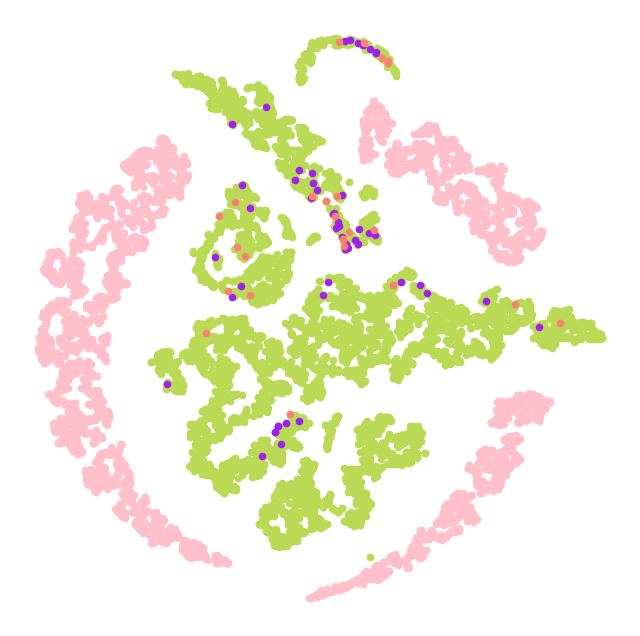

In [154]:
fig = plt.figure(1, figsize=(8, 8))
fig.clf()
colors = [
    '#ffc0cb', '#bada55', '#A020F0', '#FA8072'
]
idx_fake = [x for x in range(7392, embedded.shape[0])]
idx_real = [x for x in range(7392) if labels[x] == 0]
idx_targets_train = [x for x in idx_train if labels[x] == 1 and x < 7392]
idx_targets_test = [x for x in idx_test if labels[x] == 1 and x < 7392]
plt.scatter(z[idx_fake, 0], z[idx_fake, 1], s=20, color=colors[0])
plt.scatter(z[idx_real, 0], z[idx_real, 1], s=20, color=colors[1])
plt.scatter(z[idx_targets_train, 0], z[idx_targets_train, 1], s=20, color=colors[2])
plt.scatter(z[idx_targets_test, 0], z[idx_targets_test, 1], s=20, color=colors[3])
plt.axis('off')
    
plt.savefig(r'C:\Users\George\Desktop\ISEF-2023\Model\test\ImGAGN\embedded_plot.png', dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    
plt.show()

In [155]:
df = pd.DataFrame(embedded.detach().numpy())

print(labels)
targets_in_testing = [x for x in idx_test if labels[x] == 1]
print(targets_in_testing, len(targets_in_testing))
labeles = []

for i in range(embedded.shape[0]):
    if i in idx_real:
        labeles.append(0)
    else:
        labeles.append(1)

labeles = np.array(labeles)
df['labels'] = labels

df['protein_name'] = np.nan

# Iterate over the row indices
for i in df.index:
    try:
        # Try to get the 'name' attribute of the node
        node_name = PPI_graph.vs[i]['name']
        df.at[i, 'protein_name'] = node_name
    except IndexError:
        # If the node index does not exist in the graph, it will throw an IndexError
        # We leave the value as NaN in this case
        pass
    
print(df)
csv_filename = r'C:\Users\George\Desktop\ISEF-2023\Model\test\ImGAGN\Embedding.csv'
df.to_csv(csv_filename, index=False)


tensor([0, 0, 0,  ..., 1, 1, 1])
[tensor(3788), tensor(391), tensor(2538), tensor(3817), tensor(2333), tensor(3487), tensor(1334), tensor(5224), tensor(680), tensor(1683), tensor(4884), tensor(3832), tensor(6444), tensor(3884), tensor(6448), tensor(4744), tensor(6665), tensor(6277), tensor(5614), tensor(4328), tensor(976), tensor(6006), tensor(728), tensor(4850), tensor(3874)] 25
              0         1    2    3    4    5         6    7         8  \
0      0.853382  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000   
1      0.855595  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000   
2      0.856125  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000   
3      0.846653  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000   
4      0.855412  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000   
...         ...       ...  ...  ...  ...  ...       ...  ...       ...   
12445  0.439556  1.007159  0.0  0.0  0.0  0.0  0.323566  0.0  0.848508   
12446  0.439383  1.007405

In [161]:
print(idx_train.shape)

torch.Size([9714])


In [59]:
from imblearn.over_sampling import SMOTE

fake = [x for x in range(7392, 9892)]
#idx_train = np.concatenate((idx_train, np.array(fake)))
featu = np.array([PPI_graph.vs[key] for key in feature_keys]).T
featu = pd.DataFrame(featu)
idx_train_real = np.array([x for x in idx_train if x <= 7391])
training_x = np.concatenate((featu.iloc[idx_train_real, :], featu.iloc[idx_train_real, :], df.iloc[idx_train_real, :-2]), axis=1)
#training_x = df.iloc[idx_train_real, :-2]
training_y = df.iloc[idx_train_real, -2]
testing_y = df.iloc[idx_test, -2]
testing_x = np.concatenate((featu.iloc[idx_test, :], featu.iloc[idx_test, :], df.iloc[idx_test, :-2]), axis=1)
#testing_x = df.iloc[idx_test, :-2]

smote = SMOTE(random_state=42)
training_x_smote, training_y_smote = smote.fit_resample(training_x, training_y)

analyzing_x2 = training_x_smote
analyzing_x = np.concatenate((featu.iloc[:7392, :], featu.iloc[:7392, :], df.iloc[:7392, :-2]), axis=1)
#analyzing_x = featu.iloc[:7392, :]
#analyzing_x = df.iloc[:7392, :-2]

C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


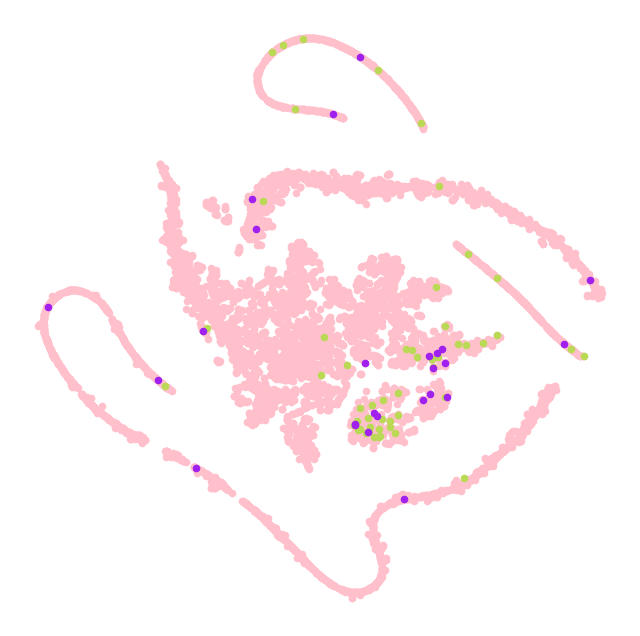

In [60]:
z2 = TSNE(n_components=2).fit_transform(analyzing_x)

fig = plt.figure(1, figsize=(8, 8))
fig.clf()
colors = [
    '#ffc0cb', '#bada55', '#A020F0', '#FA8072'
]

idx_real = [x for x in range(7392) if labels[x] == 0]
plt.scatter(z2[idx_real, 0], z2[idx_real, 1], s=20, color=colors[0])
idx_targets_train = [x for x in idx_train if labels[x] == 1 and x < 7392]
idx_targets_test = [x for x in idx_test if labels[x] == 1 and x < 7392]
plt.scatter(z2[idx_targets_train, 0], z2[idx_targets_train, 1], s=20, color=colors[1])
plt.scatter(z2[idx_targets_test, 0], z2[idx_targets_test, 1], s=20, color=colors[2])
plt.axis('off')
    
plt.savefig(r'C:\Users\George\Desktop\ISEF-2023\Model\test\ImGAGN\embedded_plot.png', dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    
plt.show()

C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


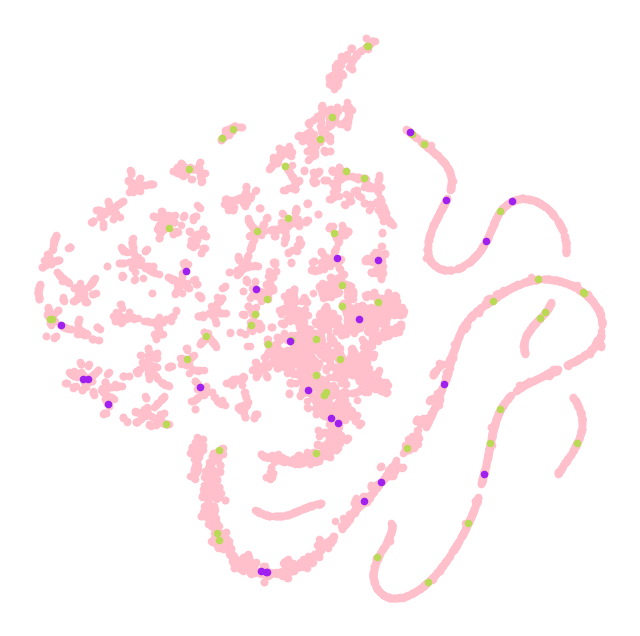

In [61]:
z2 = TSNE(n_components=2).fit_transform(analyzing_x2)

fig = plt.figure(1, figsize=(8, 8))
fig.clf()
colors = [
    '#ffc0cb', '#bada55', '#A020F0', '#FA8072'
]

idx_real = [x for x in range(7392) if labels[x] == 0]
plt.scatter(z2[idx_real, 0], z2[idx_real, 1], s=20, color=colors[0])
idx_targets_train = [x for x in idx_train if labels[x] == 1 and x < 7392]
idx_targets_test = [x for x in idx_test if labels[x] == 1 and x < 7392]
plt.scatter(z2[idx_targets_train, 0], z2[idx_targets_train, 1], s=20, color=colors[1])
plt.scatter(z2[idx_targets_test, 0], z2[idx_targets_test, 1], s=20, color=colors[2])
plt.axis('off')
    
plt.savefig(r'C:\Users\George\Desktop\ISEF-2023\Model\test\ImGAGN\embedded_plot.png', dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    
plt.show()

In [62]:
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

model = RandomForestClassifier(random_state=42)

# Dictionary to store results
results = {}

# Train and evaluate each model

    # Train the model
model.fit(training_x_smote, training_y_smote)

    # Make predictions
predictions_prob = model.predict_proba(testing_x)
print(np.max(predictions_prob[:, 1]))
predictions_prob = predictions_prob / np.max(predictions_prob[:, 1])
threshold = np.median(predictions_prob[:, 1])
print(threshold)
print(np.sort(predictions_prob[:, 1], axis=0))

threshold += 0.1

predictions = [1 if prob > threshold else 0 for prob in predictions_prob[:, 1]]
    # Calculate metrics
accuracy = model.score(testing_x, testing_y)
recall = recall_score(testing_y, predictions, zero_division=0)
f1_score_ = f1_score(testing_y, predictions)
precision = precision_score(testing_y, predictions, zero_division=0)
report = classification_report(testing_y, predictions, output_dict=True)
conf_matrix = confusion_matrix(testing_y, predictions)
matthews_coeff = matthews_corrcoef(testing_y, predictions)
auc_score = roc_auc_score(testing_y, predictions_prob[:, 1])


    # Store results
results['Random_Forest'] = {
    'Accuracy': accuracy,
    'Recall': recall,
    'Precision': precision,
    'F1 Score': f1_score_,
    'Confusion Matrix': conf_matrix,
    'Matthews Correlation Coefficient': matthews_coeff,
    'AUC': auc_score

}

# You can print the results for each model like this
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")

0.97
0.0
[0.        0.        0.        ... 0.7628866 0.8556701 1.       ]
Model: Random_Forest
Accuracy: 0.9882777276825969
Recall: 0.48
Precision: 0.10434782608695652
F1 Score: 0.17142857142857143
Confusion Matrix: [[2090  103]
 [  13   12]]
Matthews Correlation Coefficient: 0.20617743450039652
AUC: 0.8053077975376197




In [63]:
pred_prob = model.predict_proba(analyzing_x)

prob = pred_prob[:, 1]
names = np.array(df['protein_name'][:7392])

output = pd.DataFrame({
    "Name": names,
    "Probability": prob
})

output = output.sort_values(by="Probability", ascending=False)

csv_file_path = 'prediction_all.csv'
output.to_csv(csv_file_path, index=False)

my_list = ['P18507', 'P23416', 'P21918', 'P31513', 'P28472', 'P35367', 'O00591', 'P19838', 'P19634', 'P08908', 'P47869', 'Q00653', 'P18505', 'P31645', 'Q12809', 'P02768', 'P98066', 'P35348', 'P10635', 'P05067', 'Q12879', 'P08173', 'O15399', 'P14867', 'P20813', 'Q8N1C3', 'P47870', 'P08913', 'P06276', 'P21728', 'P14416', 'P35368', 'P24462', 'P46098', 'P31644', 'P20309', 'P11712', 'O14764', 'P08172', 'P20815', 'O60391', 'Q13224', 'P50406', 'P08588', 'P28566', 'Q14957', 'P22303', 'P35462', 'Q96FL8', 'Q9UNQ0', 'P25100', 'P28222', 'Q9UN88', 'P08684', 'P33261', 'P02763', 'P11229', 'P07550', 'P28223', 'O75311', 'Q9HB55', 'P21917', 'P48167', 'Q9H015', 'P22310', 'P28221', 'Q16445', 'P28335', 'P13945', 'P23415', 'P78334', 'P36544', 'P05177', 'P34903', 'P30939', 'Q99928', 'Q05586', 'P08183', 'P48169', 'Q8TCU5', 'P11509', 'P05181', 'P18089']

output = output[~output['Name'].isin(my_list)]
print(output.all)

csv_file_path = 'prediction_unknown.csv'
output.to_csv(csv_file_path, index=False)

<bound method NDFrame._add_numeric_operations.<locals>.all of         Name  Probability
2125  Q9GZZ6         0.74
3736  Q15825         0.74
5395  P43119         0.62
6140  P37058         0.51
6289  O43614         0.50
...      ...          ...
3564  P46527         0.00
3563  P05112         0.00
3562  P01135         0.00
3561  Q6MZQ0         0.00
3696  P31946         0.00

[7309 rows x 2 columns]>
